In [2]:
%pip install pillow numpy rosbags

   ---------------------------------------- 0.0/137.9 kB ? eta -:--:--
   ---------------------------------------- 137.9/137.9 kB 8.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/119.9 kB ? eta -:--:--
   ---------------------------------------- 119.9/119.9 kB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/118.2 kB ? eta -:--:--
   ---------------------------------------- 118.2/118.2 kB 6.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
%pip install tensorrt cuda-python

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 9.4 MB/s eta 0:00:02
   --- ------------------------------------ 1.0/11.1 MB 11.1 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/11.1 MB 11.1 MB/s eta 0:00:01
   ------- -------------------------------- 2.0/11.1 MB 10.5 MB/s eta 0:00:01
   ------- -------------------------------- 2.1/11.1 MB 11.1 MB/s eta 0:00:01
   --------- ------------------------------ 2.7/11.1 MB 9.5 MB/s eta 0:00:01
   ----------- ---------------------------- 3.1/11.1 MB 10.6 MB/s eta 0:00:01
   ------------- -------------------------- 3.7/11.1 MB 9.8 MB/s eta 0:00:01
   ------------------ --------------------- 5.2/11.1 MB 12.4 MB/s eta 0:00:01
   ------------------ --------------------- 5.2/11.1 MB 12.4 MB/s eta 0:00:01
   ---------------------- ----------------- 6.3/11.1 MB 12.6 MB/s eta 0:00:01
   ---------------------- ----------------- 6.3/11.1 MB 12.6 MB/s eta 0:00:


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
DIRECTION = "rear" # "front" or "rear"

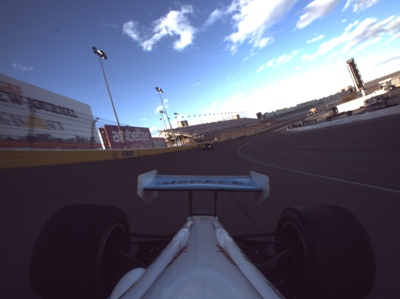

In [11]:
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore
from PIL import Image
import numpy as np
from pathlib import Path

typestore = get_typestore(Stores.LATEST)

def img_from_sensor_msg(msg):
    h, w, step = msg.height, msg.width, msg.step
    enc = msg.encoding.lower()
    buf = bytes(msg.data)
    assert enc == "rgb8", f"unsupported image encoding {enc}"
    arr = np.frombuffer(buf, dtype=np.uint8).reshape(h, step)[:, :3*w].reshape(h, w, 3)
    return Image.fromarray(arr, mode="RGB")

with AnyReader([Path("dpt_rosbag_lvms_2024_12\\rosbag2_2024_12_12-18_21_55_12.mcap")], default_typestore=typestore) as reader:

    connections = [c for c in reader.connections if c.topic == f"/vimba_{DIRECTION}/image"]
    for conn, ts, raw in reader.messages(connections=connections):
        msg = reader.deserialize(raw, conn.msgtype)
        img = img_from_sensor_msg(msg)
        break
preview = img.copy()
preview.thumbnail((400, 400))
preview

In [16]:
img.size

(2064, 1544)

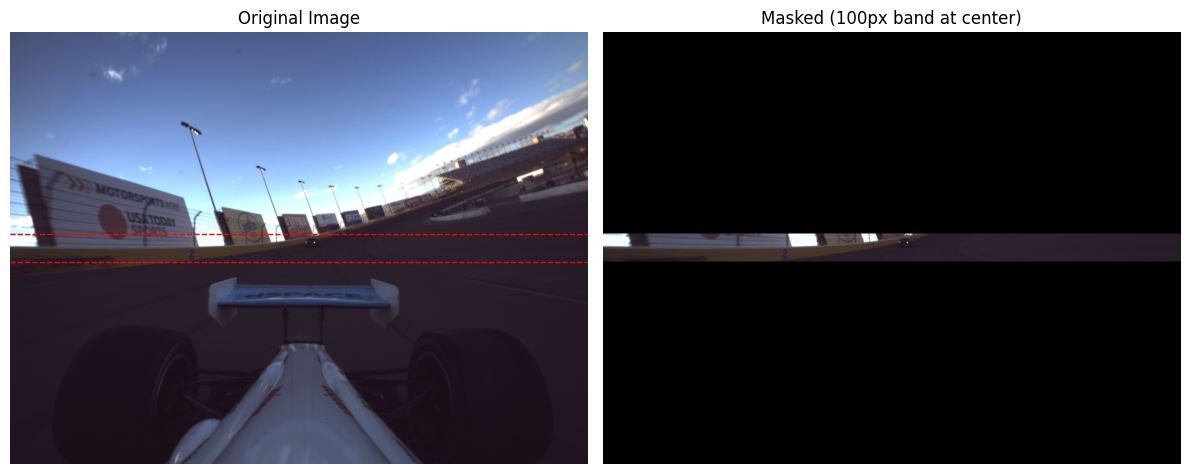

Image size: 2064x1544
Visible band: rows 722 to 822 (100 pixels)


In [17]:
# Create masked image with 100px horizontal band in vertical center
img_array = np.array(img)
height, width = img_array.shape[:2]

# Calculate vertical center band
center_y = height // 2
band_height = 100
top = center_y - band_height // 2
bottom = center_y + band_height // 2

# Create mask (all black)
masked_img_array = np.zeros_like(img_array)

# Keep only the center horizontal band
masked_img_array[top:bottom, :] = img_array[top:bottom, :]

# Convert back to PIL Image
masked_img = Image.fromarray(masked_img_array)

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axhline(y=top, color='r', linestyle='--', linewidth=1)
axes[0].axhline(y=bottom, color='r', linestyle='--', linewidth=1)
axes[0].axis('off')

axes[1].imshow(masked_img)
axes[1].set_title(f'Masked (100px band at center)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Image size: {width}x{height}")
print(f"Visible band: rows {top} to {bottom} (100 pixels)")

In [18]:
img = masked_img

In [4]:
import tensorrt as trt
import numpy as np
from pathlib import Path
import cv2

# Load TensorRT engine
ENGINE_PATH = "depth_anything_v2_518.engine"

logger = trt.Logger(trt.Logger.WARNING)
runtime = trt.Runtime(logger)

with open(ENGINE_PATH, "rb") as f:
    engine = runtime.deserialize_cuda_engine(f.read())

context = engine.create_execution_context()

print(f"Engine loaded: {ENGINE_PATH}")
print(f"Input shape: {engine.get_tensor_shape(engine.get_tensor_name(0))}")
print(f"Output shape: {engine.get_tensor_shape(engine.get_tensor_name(1))}")

Engine loaded: depth_anything_v2_518.engine
Input shape: (1, 3, 518, 518)
Output shape: (1, 1, 518, 518)


In [6]:
import torch

# Allocate device memory using PyTorch CUDA allocator
input_shape = (1, 3, 518, 518)
output_shape = (1, 1, 518, 518)

# Create torch tensors on GPU
d_input = torch.empty(input_shape, dtype=torch.float32, device='cuda')
d_output = torch.empty(output_shape, dtype=torch.float32, device='cuda')

input_size = d_input.numel() * d_input.element_size()
output_size = d_output.numel() * d_output.element_size()

print(f"Allocated GPU memory: input={input_size/1024/1024:.2f}MB, output={output_size/1024/1024:.2f}MB")
print(f"GPU: {torch.cuda.get_device_name(0)}")

Allocated GPU memory: input=3.07MB, output=1.02MB
GPU: NVIDIA GeForce RTX 5070 Ti


c:\Users\prana\Documents\Projects\berkeley\cs294-depth-anything\poc_depth_rt\.venv\Lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5070 Ti with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90.
If you want to use the NVIDIA GeForce RTX 5070 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


In [19]:
def preprocess_image(pil_image, target_size=(518, 518)):
    """Preprocess PIL image for Depth Anything V2 inference"""
    # Convert to numpy array
    img_np = np.array(pil_image).astype(np.float32) / 255.0
    
    # Resize to target size
    img_resized = cv2.resize(img_np, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Normalize using ImageNet stats
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img_normalized = (img_resized - mean) / std
    
    # Convert to CHW format and add batch dimension
    img_tensor = img_normalized.transpose(2, 0, 1)[np.newaxis, ...]
    
    return img_tensor.astype(np.float32)

def run_inference(img_tensor):
    """Run TensorRT inference on preprocessed image"""
    # Copy input to GPU
    d_input.copy_(torch.from_numpy(img_tensor))
    
    # Set tensor addresses
    context.set_tensor_address(engine.get_tensor_name(0), d_input.data_ptr())
    context.set_tensor_address(engine.get_tensor_name(1), d_output.data_ptr())
    
    # Execute inference
    success = context.execute_async_v3(torch.cuda.current_stream().cuda_stream)
    if not success:
        raise RuntimeError("Inference failed")
    
    # Synchronize and copy output back to host
    torch.cuda.synchronize()
    output = d_output.cpu().numpy().squeeze()
    
    return output


In [20]:
# Test inference on the loaded image
input_tensor = preprocess_image(img)
depth_map = run_inference(input_tensor)

print(f"Depth map shape: {depth_map.shape}")
print(f"Depth range: [{depth_map.min():.3f}, {depth_map.max():.3f}]")

Depth map shape: (518, 518)
Depth range: [0.149, 13.875]


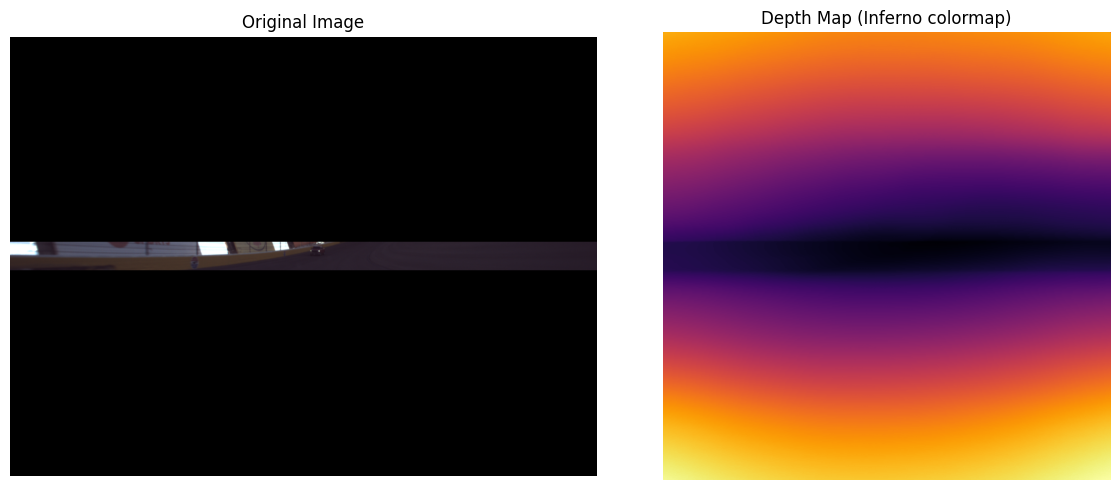

In [21]:
import matplotlib.pyplot as plt

# Visualize depth map
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

depth_colored = plt.cm.inferno(depth_map / depth_map.max())
axes[1].imshow(depth_colored)
axes[1].set_title('Depth Map (Inferno colormap)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Process all images from ROS bag
import time

depth_maps = []
timestamps = []
frame_count = 0
max_frames = 100  # Limit for testing, set to None for all frames

print(f"Processing images from topic: /vimba_{DIRECTION}/image")

with AnyReader([Path("dpt_rosbag_lvms_2024_12\\rosbag2_2024_12_12-18_21_55_12.mcap")], default_typestore=typestore) as reader:
    connections = [c for c in reader.connections if c.topic == f"/vimba_{DIRECTION}/image"]
    
    start_time = time.time()
    for conn, ts, raw in reader.messages(connections=connections):
        if max_frames and frame_count >= max_frames:
            break
            
        msg = reader.deserialize(raw, conn.msgtype)
        img = img_from_sensor_msg(msg)
        
        # Run inference
        input_tensor = preprocess_image(img)
        depth_map = run_inference(input_tensor)
        
        depth_maps.append(depth_map)
        timestamps.append(ts)
        frame_count += 1
        
        if frame_count % 10 == 0:
            elapsed = time.time() - start_time
            fps = frame_count / elapsed
            print(f"Processed {frame_count} frames, {fps:.1f} FPS")
    
    total_time = time.time() - start_time
    print(f"\nProcessed {frame_count} frames in {total_time:.2f}s")
    print(f"Average FPS: {frame_count/total_time:.1f}")

Processing images from topic: /vimba_rear/image
Processed 10 frames, 24.1 FPS
Processed 20 frames, 27.6 FPS
Processed 30 frames, 28.3 FPS
Processed 40 frames, 28.5 FPS
Processed 50 frames, 28.8 FPS
Processed 60 frames, 28.9 FPS
Processed 70 frames, 29.0 FPS
Processed 80 frames, 29.1 FPS
Processed 90 frames, 29.2 FPS
Processed 100 frames, 29.3 FPS

Processed 100 frames in 3.43s
Average FPS: 29.2


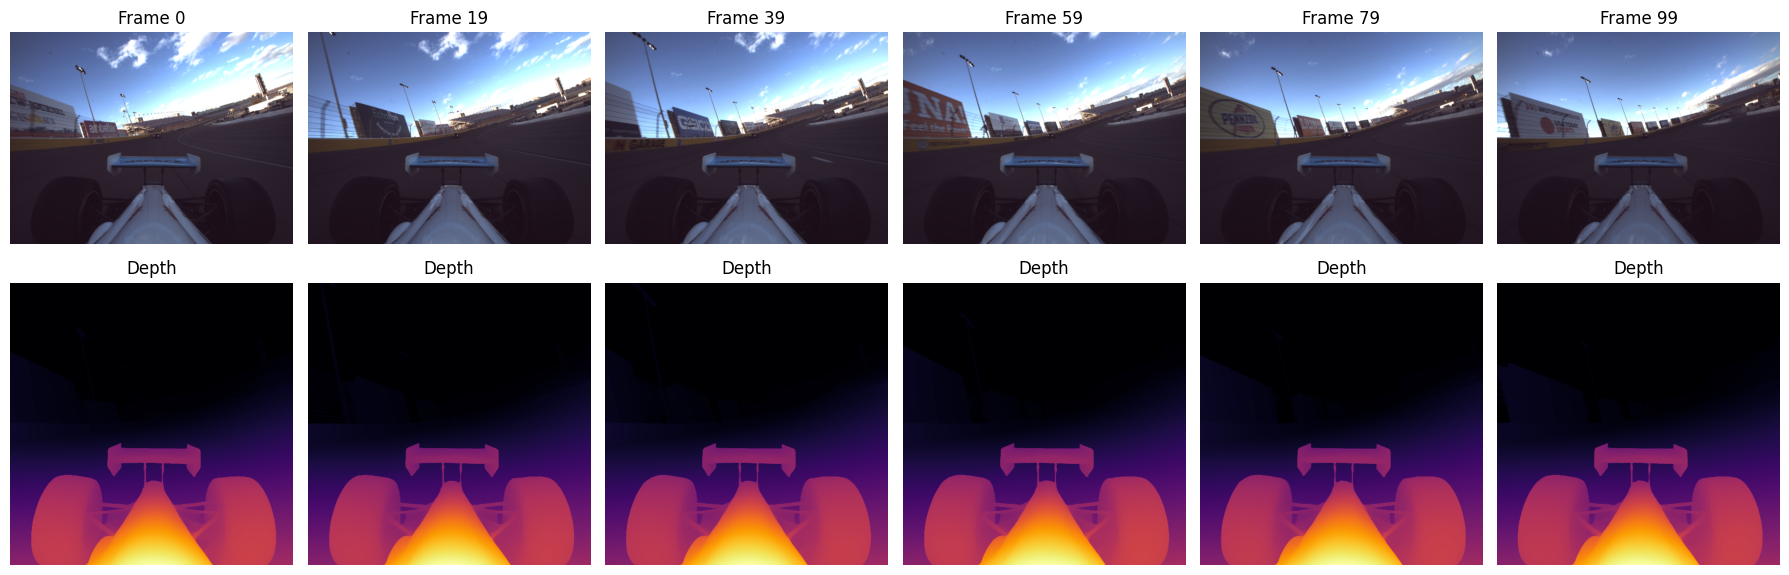

In [15]:
# Visualize a sample of processed depth maps
num_samples = min(6, len(depth_maps))
fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*3, 6))

if num_samples == 1:
    axes = axes.reshape(2, 1)

indices = np.linspace(0, len(depth_maps)-1, num_samples, dtype=int)

for i, idx in enumerate(indices):
    # Get corresponding image
    with AnyReader([Path("dpt_rosbag_lvms_2024_12\\rosbag2_2024_12_12-18_21_55_12.mcap")], default_typestore=typestore) as reader:
        connections = [c for c in reader.connections if c.topic == f"/vimba_{DIRECTION}/image"]
        for j, (conn, ts, raw) in enumerate(reader.messages(connections=connections)):
            if j == idx:
                msg = reader.deserialize(raw, conn.msgtype)
                img = img_from_sensor_msg(msg)
                break
    
    # Display original image
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Frame {idx}')
    axes[0, i].axis('off')
    
    # Display depth map
    depth_colored = plt.cm.inferno(depth_maps[idx] / depth_maps[idx].max())
    axes[1, i].imshow(depth_colored)
    axes[1, i].set_title('Depth')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()